In [1]:
import math
def plot_point(point, angle, length):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point
    # find the end point
    endy = y + length * math.sin(math.radians(angle))
    endx = x + length * math.cos(math.radians(angle))
    '''# plot the points
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_ylim([0, 150])   # set the bounds to be 10, 10
    ax.set_xlim([0, 150])
    ax.plot([x, endx], [y, endy])
    fig.show()
    '''
    return((endx,endy))

     
plot_point((25498165.4,6677093.8),46,100)
plot_point((10,1000), 55, 100)

(67.35764363510461, 1081.9152044288992)

In [2]:
import numpy as np
import math
from trianglesolver import solve, degree
def directions(line_angle,angle):
    x_or_y = True
    if angle >= 45 & angle < 135:
        line_angle_grouped = line_angle.groupby('centroid_y').mean()
        line_angle_grouped.sort_values(by='centroid_y')
    if angle >= 135 & angle < 225:
        line_angle_grouped = line_angle.groupby('centroid_x').mean()
        line_angle_grouped.sort_values(by='centroid_x', ascending=False)
        x_or_y = False
    if angle >= 225 & angle < 315:
        line_angle_grouped = line_angle.groupby('centroid_y').mean()
        line_angle_grouped.sort_values(by='centroid_y', ascending=False)
    if angle >= 315 % (angle >=0 &angle < 45):
        line_angle_grouped = line_angle.groupby('centroid_x').mean()
        line_angle_grouped.sort_values(by='centroid_x')
        x_or_y = False    
    return line_angle_grouped, x_or_y

    
def angler(intersections, point, angle,point_join):
    
    line_angle = intersections[intersections['angle_of_line'] == angle]
    line_angle["centroid_x"] = line_angle.centroid.x
    line_angle["centroid_y"] = line_angle.centroid.y
    line_angle_grouped, x_or_y = directions(line_angle,angle)
    
    height = point_join + 1.5
    max_angle = 0
    objects = []
    veg_amount = 0
    for idx, row in line_angle_grouped.iterrows():       
            #d=root(x2−x1)2+(y2−y1)2+(z2−z1)2

        if x_or_y == False:
            maa_max = np.sqrt((idx-point.x)**2+(row['centroid_y']-point.y)**2+(row['z_average']-(height-1.5))**2)
            hum_max = np.sqrt((idx-point.x)**2+(row['centroid_y']-point.y)**2+(row['z_average']-height)**2)
            
        if x_or_y == True: 
            maa_max = np.sqrt((row['centroid_x']-point.x)**2+(idx-point.y)**2+(row['z_average']-(height-1.5))**2)
            hum_max = np.sqrt((row['centroid_x']-point.x)**2+(idx-point.y)**2+(row['z_average']-height)**2)
        
        # From Cosine law 
        
        a,b,c,A,B,C = solve(a=1.5,b=hum_max,c=maa_max)
        view_area = C/degree
        
        if view_area > max_angle:
            objects.append({'start':max_angle,'end':view_area,'type':row['green_r'],'z_average':row['z_average']})
            if row['green_r'] > 0:
                veg_amount = veg_amount + (view_area-max_angle)
            
            # print(maa_max,hum_max)
            # print(view_area,max_angle)
            #print(height,row['z_max'])
            
            max_angle = view_area
    objects.append({'start':max_angle,'end':180,'type':0,'z_max':9999})
    
    return veg_amount, objects

In [4]:
from shapely.geometry import Point, LineString, shape
from pyproj import _datadir, datadir
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
from rasterio.mask import mask

points = gpd.read_file("saititshp.shp")
grid= gpd.read_file("rak_merged_green.shp")
print('join starting')
points = gpd.sjoin(points,grid,how="left",op='intersects')
print('join complete')

join starting
join complete


In [5]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [6]:
grid.to_crs(epsg=3879, inplace=True)
points = points.drop_duplicates(subset=['fid'])
kopio1 = points
kopio2 = grid

In [7]:
points = kopio1
grid = kopio2

In [8]:
kopio3 = points

In [9]:
points.to_crs(epsg=3879, inplace=True)
points.drop('geometry',axis=1).to_csv('gsr.csv') 


In [10]:
pd.options.mode.chained_assignment = None

In [11]:
all_objects = []
for i_i, point_row in points.iterrows():
    objects_of_point = []
    objects_of_point.append(int(point_row['fid']))
    print(i_i)
    point = points.loc[i_i]
    print(len(point))
    point_join = point['z_average']
    print(point.geometry.y,point.geometry.x)
    dictionary_list = []
    '''for a in range(360):
        
        line = LineString([(point_row.geometry.x,point_row.geometry.y),plot_point((point_row.geometry.x,point_row.geometry.y),a,100)])
        dictionary_list.append({'angle_of_line':a,'geometry': line})'''
    print("creating views")
    for a in range(360):
        line = LineString([(point.geometry.x,point.geometry.y),plot_point((point.geometry.x,point.geometry.y),a,100)])
        dictionary_list.append({'angle_of_line':a,'geometry': line})
    view = gpd.GeoDataFrame(dictionary_list)
    print("views finished")
    view.set_crs(epsg=3879, inplace=True)
    view['geometry'] = view.geometry.buffer(0.5)
    print("join2 starting")
    better_inter = gpd.sjoin(grid,view,how="inner")
    print("join2 ended")
    #view.to_file("muotoja/view_lines_test.shp")
    #affine_z = z_src.transform
    #out_img, out_transform = mask(dataset=z_src, shapes=view, crop=True)

    #view['green'] = 0
    green_in_point = 0
    objects = []
    for i in range(0,360):
        
        green, obj = angler(better_inter ,point_row.geometry, i,point_join)
        green_in_point = green_in_point + green
        objects.append(obj)
    points.loc[i_i,'green'] = (green_in_point/360)/1.8
    objects_of_point.append(objects)
    all_objects.append(objects_of_point)
    print((green_in_point/360)/1.8)
#points.to_file("points_tosiuuss.shp")

0
79
6672029.499834282 25492218.905783977
creating views
views finished
join2 starting
join2 ended
53.37267093606471
1
79
6676712.979104785 25495096.126281925
creating views
views finished
join2 starting
join2 ended
69.44627032914651
2
79
6676996.639347048 25497437.442060284
creating views
views finished
join2 starting
join2 ended
67.05371917931582
3
79
6675053.538571288 25502082.978246436
creating views
views finished
join2 starting
join2 ended
28.655040624856408
4
79
6673785.022813161 25502884.176695235
creating views
views finished
join2 starting
join2 ended
21.32173425509635
5
79
6674524.9561137585 25500653.317609888
creating views
views finished
join2 starting
join2 ended
53.21076265185461
6
79
6673270.280581614 25497591.335138813
creating views
views finished
join2 starting
join2 ended
4.203982550251893
7
79
6683588.853785145 25493846.273776703
creating views
views finished
join2 starting
join2 ended
75.77291404919829
8
79
6675346.46042969 25494867.55845046
creating views
views f

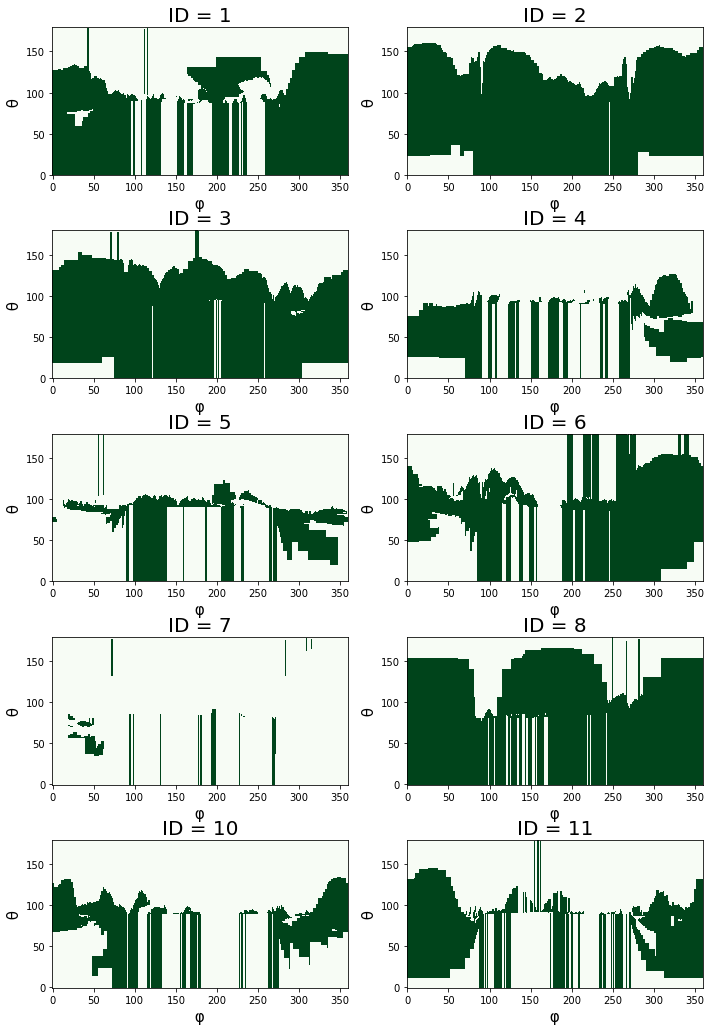

In [113]:

fids = [1,2,3,4,5,6,7,8,10,11,12,13,14,15,20,21,22,23,25,27]


from PIL import Image
import matplotlib.pyplot as plt


first_10 = all_objects[:10]

fig, axes = plt.subplots(5,2,figsize=(10, 15))

fid = 0
row = 0
column = 0
for image in first_10:
    if column == 2:
        row = row +1 
        column = 0
    grid = []
    ax = axes[row,column]
    for whole in image[1]:
        vert = []
        prev = 0.0001
        for slic in whole:
            start = math.ceil(slic['start'])
            end = math.ceil(slic['end'])
            veg = 1
            
            
            
            if slic['type'] == 0.0:
                veg = 0
            #print(start,end,veg)
            if prev != start or end + 1 > prev:
                for i in range(start,end):
                
                    vert.insert(i,veg)
            prev = start
        grid.append(vert)

    arr = np.asarray(grid).astype('uint8')*20
    arr = np.transpose(arr)

    im = Image.fromarray(arr)

    ax.set_title('ID = ' +str(fids[fid]),fontsize = 20)
    ax.set_xlabel(' φ ',fontsize=15)
    ax.set_ylabel(' θ ',fontsize=15)
    
    ax.imshow(im,cmap='Greens',origin='lower')
    column = column +1 
    fid = fid +1
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig('gsr_dip.png',dpi=600)

In [70]:
len(grid[0])

180

In [71]:
out_meta = z_src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})
with rasterio.open("muotoja/2/crop_test.tif", "w", **out_meta ) as dest:
    dest.write(out_img)

In [83]:
grid

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,